In [2]:
import os
import sys
import requests
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, classification_report

import yfinance as yf


In [3]:


def grab_price_data():
    #tickers_list = ['JPM', 'COST', 'IBM', 'HD', 'ARWR']
    tickers_list = ['GOG','AMD','META']

# Store multiple result sets.
    end_date = datetime.now().strftime('%Y-%m-%d')
    full_price_history = []

    for ticker in tickers_list:
        price_history = yf.Ticker(ticker).history(period='max', start='2023-06-01', end=end_date, interval='1d')

        for index, row in price_history.iterrows():
            row_data = row.to_dict()
            row_data['symbol'] = ticker
            row_data['datetime'] = index.strftime('%Y-%m-%d')  # Convert Pandas Timestamp to datetime string
            full_price_history.append(row_data)


    price_data = pd.DataFrame(full_price_history)
    price_data.to_csv('price_data.csv', index=False)
    price_data
    


In [4]:
if os.path.exists('./data/price_data.csv'):
    
    # Load the data
    price_data = pd.read_csv('price_data.csv')

else:

    # Grab the data and store it.
    grab_price_data()

    # Load the data
    price_data = pd.read_csv('price_data.csv')

# Display the head before moving on.
price_data.head()



GOG: No price data found, symbol may be delisted (1d 2023-06-01 -> 2024-02-13)


,Open,High,Low,Close,Volume,Dividends,Stock Splits,symbol,datetime
0,117.290001,121.279999,116.599998,119.470001,66032900.0,0.0,0.0,AMD,2023-06-01
1,120.750000,121.660004,117.680000,117.860001,52331100.0,0.0,0.0,AMD,2023-06-02
2,116.589996,119.320000,116.419998,117.930000,52602900.0,0.0,0.0,AMD,2023-06-05
3,117.910004,124.419998,117.739998,124.230003,75257500.0,0.0,0.0,AMD,2023-06-06
4,124.029999,125.339996,117.070000,117.830002,81755200.0,0.0,0.0,AMD,2023-06-07


In [5]:


price_data_ro = price_data
price_data = price_data_ro[['datetime', 'symbol', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']] # rearrange column here
price_data.to_csv('./price_data_ro.csv')

price_data.head()


,datetime,symbol,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2023-06-01,AMD,117.290001,121.279999,116.599998,119.470001,66032900.0,0.0,0.0
1,2023-06-02,AMD,120.750000,121.660004,117.680000,117.860001,52331100.0,0.0,0.0
2,2023-06-05,AMD,116.589996,119.320000,116.419998,117.930000,52602900.0,0.0,0.0
3,2023-06-06,AMD,117.910004,124.419998,117.739998,124.230003,75257500.0,0.0,0.0
4,2023-06-07,AMD,124.029999,125.339996,117.070000,117.830002,81755200.0,0.0,0.0


In [6]:

price_data.sort_values(by = ['symbol','datetime'], inplace = True)

# calculate the change in price
price_data['change_in_price'] = price_data['Close'].diff()

price_data.head()


,datetime,symbol,Open,High,Low,Close,Volume,Dividends,Stock Splits,change_in_price
0,2023-06-01,AMD,117.290001,121.279999,116.599998,119.470001,66032900.0,0.0,0.0,NaN
1,2023-06-02,AMD,120.750000,121.660004,117.680000,117.860001,52331100.0,0.0,0.0,-1.610001
2,2023-06-05,AMD,116.589996,119.320000,116.419998,117.930000,52602900.0,0.0,0.0,0.070000
3,2023-06-06,AMD,117.910004,124.419998,117.739998,124.230003,75257500.0,0.0,0.0,6.300003
4,2023-06-07,AMD,124.029999,125.339996,117.070000,117.830002,81755200.0,0.0,0.0,-6.400002


In [7]:

mask = price_data['symbol'] != price_data['symbol'].shift(1)

# For those rows, let's make the value null
price_data['change_in_price'] = np.where(mask == True, np.nan, price_data['change_in_price'])

# print the rows that have a null value, should only be 5
price_data[price_data.isna().any(axis = 1)]


,datetime,symbol,Open,High,Low,Close,Volume,Dividends,Stock Splits,change_in_price
0,2023-06-01,AMD,117.290001,121.279999,116.599998,119.470001,66032900.0,0.0,0.0,NaN
176,2023-06-01,META,265.899994,274.000000,265.890015,272.609985,25609500.0,0.0,0.0,NaN


In [8]:

# define the number of days out you want to predict
days_out = 30

# Group by symbol, then apply the rolling function and grab the Min and Max.
price_data_smoothed = price_data.groupby(['symbol'])[['Close','Low','High','Open','Volume']].transform(lambda x: x.ewm(span = days_out).mean())

# Join the smoothed columns with the symbol and datetime column from the old data frame.
smoothed_df = pd.concat([price_data[['symbol','datetime']], price_data_smoothed], axis=1, sort=False)

smoothed_df


,symbol,datetime,Close,Low,High,Open,Volume
0,AMD,2023-06-01,119.470001,116.599998,121.279999,117.290001,6.603290e+07
1,AMD,2023-06-02,118.638168,117.157999,121.476335,119.077667,5.895364e+07
2,AMD,2023-06-05,118.386206,116.895423,120.709123,118.192568,5.669408e+07
3,AMD,2023-06-06,119.996385,117.128134,121.731605,118.114712,6.180898e+07
4,AMD,2023-06-07,119.503480,117.114907,122.552601,119.460583,6.634723e+07
...,...,...,...,...,...,...,...
347,META,2024-02-06,388.264697,383.548504,393.524148,387.776554,2.301561e+07
348,META,2024-02-07,393.511542,388.234452,398.556186,392.307143,2.301886e+07
349,META,2024-02-08,398.446326,393.189049,403.203571,397.211244,2.274765e+07
350,META,2024-02-09,402.940794,397.981409,407.744670,402.097658,2.246705e+07


In [9]:

days_out = 30

# create a new column that will house the flag, and for each group calculate the diff compared to 30 days ago. Then use Numpy to define the sign.
smoothed_df['Signal_Flag'] = smoothed_df.groupby('symbol')['Close'].transform(lambda x : np.sign(x.diff(days_out)))

# print the first 50 rows
smoothed_df.head(50)


,symbol,datetime,Close,Low,High,Open,Volume,Signal_Flag
0,AMD,2023-06-01,119.470001,116.599998,121.279999,117.290001,6.603290e+07,NaN
1,AMD,2023-06-02,118.638168,117.157999,121.476335,119.077667,5.895364e+07,NaN
2,AMD,2023-06-05,118.386206,116.895423,120.709123,118.192568,5.669408e+07,NaN
3,AMD,2023-06-06,119.996385,117.128134,121.731605,118.114712,6.180898e+07,NaN
4,AMD,2023-06-07,119.503480,117.114907,122.552601,119.460583,6.634723e+07,NaN
5,AMD,2023-06-08,119.806033,117.102210,122.485576,119.233533,6.613197e+07,NaN
6,AMD,2023-06-09,120.690527,118.217398,123.309614,119.983554,6.767467e+07,NaN
7,AMD,2023-06-12,122.016750,119.494178,124.428452,121.315546,7.043964e+07,NaN
8,AMD,2023-06-13,122.376026,119.916721,125.629477,122.888666,7.930590e+07,NaN
9,AMD,2023-06-14,123.032704,120.432797,125.907914,123.371345,8.150396e+07,NaN


In [10]:

# Calculate the 14 day RSI
n = 14

# First make a copy of the data frame twice
up_df, down_df = price_data[['symbol','change_in_price']].copy(), price_data[['symbol','change_in_price']].copy()

# For up days, if the change is less than 0 set to 0.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# For down days, if the change is greater than 0 set to 0.
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# We need change in price to be absolute.
down_df['change_in_price'] = down_df['change_in_price'].abs()

# Calculate the EWMA (Exponential Weighted Moving Average), meaning older values are given less weight compared to newer values.
ewma_up = up_df.groupby('symbol')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('symbol')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

# Calculate the Relative Strength
relative_strength = ewma_up / ewma_down

# Calculate the Relative Strength Index
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

# Add the info to the data frame.
price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = up_df['change_in_price']
price_data['RSI'] = relative_strength_index

# Display the head.
price_data.head(30)


,datetime,symbol,Open,High,Low,Close,Volume,Dividends,Stock Splits,change_in_price,down_days,up_days,RSI
0,2023-06-01,AMD,117.290001,121.279999,116.599998,119.470001,66032900.0,0.0,0.0,NaN,NaN,NaN,NaN
1,2023-06-02,AMD,120.750000,121.660004,117.680000,117.860001,52331100.0,0.0,0.0,-1.610001,1.610001,0.000000,0.000000
2,2023-06-05,AMD,116.589996,119.320000,116.419998,117.930000,52602900.0,0.0,0.0,0.070000,0.000000,0.070000,4.777049
3,2023-06-06,AMD,117.910004,124.419998,117.739998,124.230003,75257500.0,0.0,0.0,6.300003,0.000000,6.300003,84.025153
4,2023-06-07,AMD,124.029999,125.339996,117.070000,117.830002,81755200.0,0.0,0.0,-6.400002,6.400002,0.000000,42.533265
5,2023-06-08,AMD,118.300003,122.209999,117.050003,121.050003,65246900.0,0.0,0.0,3.220001,0.000000,3.220001,55.336747
6,2023-06-09,AMD,123.570000,127.250000,123.550003,124.919998,75051600.0,0.0,0.0,3.869995,0.000000,3.869995,65.879041
7,2023-06-12,AMD,128.520004,130.479996,126.400002,129.190002,85394700.0,0.0,0.0,4.270004,0.000000,4.270004,73.763284
8,2023-06-13,AMD,132.320007,132.830002,122.449997,124.529999,132461900.0,0.0,0.0,-4.660004,4.660004,0.000000,57.137982
9,2023-06-14,AMD,126.529999,127.730003,123.809998,127.330002,95888100.0,0.0,0.0,2.800003,0.000000,2.800003,62.930486


In [11]:

# Calculate the Stochastic Oscillator
n = 14

# Make a copy of the high and low column.
low_14, high_14 = price_data[['symbol','Low']].copy(), price_data[['symbol','High']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14.groupby('symbol')['Low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('symbol')['High'].transform(lambda x: x.rolling(window = n).max())

# Calculate the Stochastic Oscillator.
k_percent = 100 * ((price_data['Close'] - low_14) / (high_14 - low_14))

# Add the info to the data frame.
price_data['low_14'] = low_14
price_data['high_14'] = high_14
price_data['k_percent'] = k_percent

# Display the head.
price_data.head(30)


,datetime,symbol,Open,High,Low,Close,Volume,Dividends,Stock Splits,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent
0,2023-06-01,AMD,117.290001,121.279999,116.599998,119.470001,66032900.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-06-02,AMD,120.750000,121.660004,117.680000,117.860001,52331100.0,0.0,0.0,-1.610001,1.610001,0.000000,0.000000,NaN,NaN,NaN
2,2023-06-05,AMD,116.589996,119.320000,116.419998,117.930000,52602900.0,0.0,0.0,0.070000,0.000000,0.070000,4.777049,NaN,NaN,NaN
3,2023-06-06,AMD,117.910004,124.419998,117.739998,124.230003,75257500.0,0.0,0.0,6.300003,0.000000,6.300003,84.025153,NaN,NaN,NaN
4,2023-06-07,AMD,124.029999,125.339996,117.070000,117.830002,81755200.0,0.0,0.0,-6.400002,6.400002,0.000000,42.533265,NaN,NaN,NaN
5,2023-06-08,AMD,118.300003,122.209999,117.050003,121.050003,65246900.0,0.0,0.0,3.220001,0.000000,3.220001,55.336747,NaN,NaN,NaN
6,2023-06-09,AMD,123.570000,127.250000,123.550003,124.919998,75051600.0,0.0,0.0,3.869995,0.000000,3.869995,65.879041,NaN,NaN,NaN
7,2023-06-12,AMD,128.520004,130.479996,126.400002,129.190002,85394700.0,0.0,0.0,4.270004,0.000000,4.270004,73.763284,NaN,NaN,NaN
8,2023-06-13,AMD,132.320007,132.830002,122.449997,124.529999,132461900.0,0.0,0.0,-4.660004,4.660004,0.000000,57.137982,NaN,NaN,NaN
9,2023-06-14,AMD,126.529999,127.730003,123.809998,127.330002,95888100.0,0.0,0.0,2.800003,0.000000,2.800003,62.930486,NaN,NaN,NaN


In [12]:

# Calculate the Williams %R
n = 14

# Make a copy of the high and low column.
low_14, high_14 = price_data[['symbol','Low']].copy(), price_data[['symbol','High']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14.groupby('symbol')['Low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('symbol')['High'].transform(lambda x: x.rolling(window = n).max())

# Calculate William %R indicator.
r_percent = ((high_14 - price_data['Close']) / (high_14 - low_14)) * - 100

# Add the info to the data frame.
price_data['r_percent'] = r_percent

# Display the head.
price_data.head(30)


,datetime,symbol,Open,High,Low,Close,Volume,Dividends,Stock Splits,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent
0,2023-06-01,AMD,117.290001,121.279999,116.599998,119.470001,66032900.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-06-02,AMD,120.750000,121.660004,117.680000,117.860001,52331100.0,0.0,0.0,-1.610001,1.610001,0.000000,0.000000,NaN,NaN,NaN,NaN
2,2023-06-05,AMD,116.589996,119.320000,116.419998,117.930000,52602900.0,0.0,0.0,0.070000,0.000000,0.070000,4.777049,NaN,NaN,NaN,NaN
3,2023-06-06,AMD,117.910004,124.419998,117.739998,124.230003,75257500.0,0.0,0.0,6.300003,0.000000,6.300003,84.025153,NaN,NaN,NaN,NaN
4,2023-06-07,AMD,124.029999,125.339996,117.070000,117.830002,81755200.0,0.0,0.0,-6.400002,6.400002,0.000000,42.533265,NaN,NaN,NaN,NaN
5,2023-06-08,AMD,118.300003,122.209999,117.050003,121.050003,65246900.0,0.0,0.0,3.220001,0.000000,3.220001,55.336747,NaN,NaN,NaN,NaN
6,2023-06-09,AMD,123.570000,127.250000,123.550003,124.919998,75051600.0,0.0,0.0,3.869995,0.000000,3.869995,65.879041,NaN,NaN,NaN,NaN
7,2023-06-12,AMD,128.520004,130.479996,126.400002,129.190002,85394700.0,0.0,0.0,4.270004,0.000000,4.270004,73.763284,NaN,NaN,NaN,NaN
8,2023-06-13,AMD,132.320007,132.830002,122.449997,124.529999,132461900.0,0.0,0.0,-4.660004,4.660004,0.000000,57.137982,NaN,NaN,NaN,NaN
9,2023-06-14,AMD,126.529999,127.730003,123.809998,127.330002,95888100.0,0.0,0.0,2.800003,0.000000,2.800003,62.930486,NaN,NaN,NaN,NaN


In [13]:

# Calculate the MACD
ema_26 = price_data.groupby('symbol')['Close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_data.groupby('symbol')['Close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculate the EMA
ema_9_macd = macd.ewm(span = 9).mean()

# Store the data in the data frame.
price_data['MACD'] = macd
price_data['MACD_EMA'] = ema_9_macd

# Print the head.
price_data.head(30)


,datetime,symbol,Open,High,Low,Close,Volume,Dividends,Stock Splits,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA
0,2023-06-01,AMD,117.290001,121.279999,116.599998,119.470001,66032900.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
1,2023-06-02,AMD,120.750000,121.660004,117.680000,117.860001,52331100.0,0.0,0.0,-1.610001,1.610001,0.000000,0.000000,NaN,NaN,NaN,NaN,-0.036122,-0.020068
2,2023-06-05,AMD,116.589996,119.320000,116.419998,117.930000,52602900.0,0.0,0.0,0.070000,0.000000,0.070000,4.777049,NaN,NaN,NaN,NaN,-0.043856,-0.029817
3,2023-06-06,AMD,117.910004,124.419998,117.739998,124.230003,75257500.0,0.0,0.0,6.300003,0.000000,6.300003,84.025153,NaN,NaN,NaN,NaN,0.181161,0.041653
4,2023-06-07,AMD,124.029999,125.339996,117.070000,117.830002,81755200.0,0.0,0.0,-6.400002,6.400002,0.000000,42.533265,NaN,NaN,NaN,NaN,0.044947,0.042632
5,2023-06-08,AMD,118.300003,122.209999,117.050003,121.050003,65246900.0,0.0,0.0,3.220001,0.000000,3.220001,55.336747,NaN,NaN,NaN,NaN,0.099908,0.058157
6,2023-06-09,AMD,123.570000,127.250000,123.550003,124.919998,75051600.0,0.0,0.0,3.869995,0.000000,3.869995,65.879041,NaN,NaN,NaN,NaN,0.308751,0.121576
7,2023-06-12,AMD,128.520004,130.479996,126.400002,129.190002,85394700.0,0.0,0.0,4.270004,0.000000,4.270004,73.763284,NaN,NaN,NaN,NaN,0.646904,0.247822
8,2023-06-13,AMD,132.320007,132.830002,122.449997,124.529999,132461900.0,0.0,0.0,-4.660004,4.660004,0.000000,57.137982,NaN,NaN,NaN,NaN,0.640025,0.338423
9,2023-06-14,AMD,126.529999,127.730003,123.809998,127.330002,95888100.0,0.0,0.0,2.800003,0.000000,2.800003,62.930486,NaN,NaN,NaN,NaN,0.770060,0.435135


In [14]:

# Calculate the Price Rate of Change
n = 9

# Calculate the Rate of Change in the Price, and store it in the Data Frame.
price_data['Price_Rate_Of_Change'] = price_data.groupby('symbol')['Close'].transform(lambda x: x.pct_change(periods = n))

# Print the first 30 rows
price_data.head(30)


,datetime,symbol,Open,High,Low,Close,Volume,Dividends,Stock Splits,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change
0,2023-06-01,AMD,117.290001,121.279999,116.599998,119.470001,66032900.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
1,2023-06-02,AMD,120.750000,121.660004,117.680000,117.860001,52331100.0,0.0,0.0,-1.610001,1.610001,0.000000,0.000000,NaN,NaN,NaN,NaN,-0.036122,-0.020068,NaN
2,2023-06-05,AMD,116.589996,119.320000,116.419998,117.930000,52602900.0,0.0,0.0,0.070000,0.000000,0.070000,4.777049,NaN,NaN,NaN,NaN,-0.043856,-0.029817,NaN
3,2023-06-06,AMD,117.910004,124.419998,117.739998,124.230003,75257500.0,0.0,0.0,6.300003,0.000000,6.300003,84.025153,NaN,NaN,NaN,NaN,0.181161,0.041653,NaN
4,2023-06-07,AMD,124.029999,125.339996,117.070000,117.830002,81755200.0,0.0,0.0,-6.400002,6.400002,0.000000,42.533265,NaN,NaN,NaN,NaN,0.044947,0.042632,NaN
5,2023-06-08,AMD,118.300003,122.209999,117.050003,121.050003,65246900.0,0.0,0.0,3.220001,0.000000,3.220001,55.336747,NaN,NaN,NaN,NaN,0.099908,0.058157,NaN
6,2023-06-09,AMD,123.570000,127.250000,123.550003,124.919998,75051600.0,0.0,0.0,3.869995,0.000000,3.869995,65.879041,NaN,NaN,NaN,NaN,0.308751,0.121576,NaN
7,2023-06-12,AMD,128.520004,130.479996,126.400002,129.190002,85394700.0,0.0,0.0,4.270004,0.000000,4.270004,73.763284,NaN,NaN,NaN,NaN,0.646904,0.247822,NaN
8,2023-06-13,AMD,132.320007,132.830002,122.449997,124.529999,132461900.0,0.0,0.0,-4.660004,4.660004,0.000000,57.137982,NaN,NaN,NaN,NaN,0.640025,0.338423,NaN
9,2023-06-14,AMD,126.529999,127.730003,123.809998,127.330002,95888100.0,0.0,0.0,2.800003,0.000000,2.800003,62.930486,NaN,NaN,NaN,NaN,0.770060,0.435135,0.065791


In [15]:

def obv(group):
    
    # Grab the volume and close column.
    volume = group['Volume']
    change = group['Close'].diff()

    # intialize the previous OBV
    prev_obv = 0
    obv_values = []

    # calculate the On Balance Volume
    for i, j in zip(change, volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        # OBV.append(current_OBV)
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    # Return a panda series.
    return pd.Series(obv_values, index = group.index)
        

# apply the function to each group
obv_groups = price_data.groupby('symbol').apply(obv)

# add to the data frame, but drop the old index, before adding it.
price_data['On Balance Volume'] = obv_groups.reset_index(level=0, drop=True)

# display the data frame.
price_data.head(30)


,datetime,symbol,Open,High,Low,Close,Volume,Dividends,Stock Splits,change_in_price,...,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
0,2023-06-01,AMD,117.290001,121.279999,116.599998,119.470001,66032900.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.0
1,2023-06-02,AMD,120.750000,121.660004,117.680000,117.860001,52331100.0,0.0,0.0,-1.610001,...,0.000000,0.000000,NaN,NaN,NaN,NaN,-0.036122,-0.020068,NaN,-52331100.0
2,2023-06-05,AMD,116.589996,119.320000,116.419998,117.930000,52602900.0,0.0,0.0,0.070000,...,0.070000,4.777049,NaN,NaN,NaN,NaN,-0.043856,-0.029817,NaN,271800.0
3,2023-06-06,AMD,117.910004,124.419998,117.739998,124.230003,75257500.0,0.0,0.0,6.300003,...,6.300003,84.025153,NaN,NaN,NaN,NaN,0.181161,0.041653,NaN,75529300.0
4,2023-06-07,AMD,124.029999,125.339996,117.070000,117.830002,81755200.0,0.0,0.0,-6.400002,...,0.000000,42.533265,NaN,NaN,NaN,NaN,0.044947,0.042632,NaN,-6225900.0
5,2023-06-08,AMD,118.300003,122.209999,117.050003,121.050003,65246900.0,0.0,0.0,3.220001,...,3.220001,55.336747,NaN,NaN,NaN,NaN,0.099908,0.058157,NaN,59021000.0
6,2023-06-09,AMD,123.570000,127.250000,123.550003,124.919998,75051600.0,0.0,0.0,3.869995,...,3.869995,65.879041,NaN,NaN,NaN,NaN,0.308751,0.121576,NaN,134072600.0
7,2023-06-12,AMD,128.520004,130.479996,126.400002,129.190002,85394700.0,0.0,0.0,4.270004,...,4.270004,73.763284,NaN,NaN,NaN,NaN,0.646904,0.247822,NaN,219467300.0
8,2023-06-13,AMD,132.320007,132.830002,122.449997,124.529999,132461900.0,0.0,0.0,-4.660004,...,0.000000,57.137982,NaN,NaN,NaN,NaN,0.640025,0.338423,NaN,87005400.0
9,2023-06-14,AMD,126.529999,127.730003,123.809998,127.330002,95888100.0,0.0,0.0,2.800003,...,2.800003,62.930486,NaN,NaN,NaN,NaN,0.770060,0.435135,0.065791,182893500.0


In [16]:

# Create a column we wish to predict
'''
    In this case, let's create an output column that will be 1 if the closing price at time 't' is greater than 't-1' and 0 otherwise.
    In other words, if the today's closing price is greater than yesterday's closing price it would be 1.
'''

# Group by the `Symbol` column, then grab the `Close` column.
close_groups = price_data.groupby('symbol')['Close']

# Apply the lambda function which will return -1.0 for down, 1.0 for up and 0.0 for no change.
close_groups = close_groups.transform(lambda x : np.sign(x.diff()))

# add the data to the main dataframe.
price_data['Prediction'] = close_groups

# for simplicity in later sections I'm going to make a change to our prediction column. To keep this as a binary classifier I'll change flat days and consider them up days.
price_data.loc[price_data['Prediction'] == 0.0] = 1.0

# print the head
price_data.head(50)
# OPTIONAL CODE: Dump the data frame to a CSV file to examine the data yourself.
# price_data.to_csv('final_metrics.csv')


,datetime,symbol,Open,High,Low,Close,Volume,Dividends,Stock Splits,change_in_price,...,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Prediction
0,2023-06-01,AMD,117.290001,121.279999,116.599998,119.470001,66032900.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.0,NaN
1,2023-06-02,AMD,120.750000,121.660004,117.680000,117.860001,52331100.0,0.0,0.0,-1.610001,...,0.000000,NaN,NaN,NaN,NaN,-0.036122,-0.020068,NaN,-52331100.0,-1.0
2,2023-06-05,AMD,116.589996,119.320000,116.419998,117.930000,52602900.0,0.0,0.0,0.070000,...,4.777049,NaN,NaN,NaN,NaN,-0.043856,-0.029817,NaN,271800.0,1.0
3,2023-06-06,AMD,117.910004,124.419998,117.739998,124.230003,75257500.0,0.0,0.0,6.300003,...,84.025153,NaN,NaN,NaN,NaN,0.181161,0.041653,NaN,75529300.0,1.0
4,2023-06-07,AMD,124.029999,125.339996,117.070000,117.830002,81755200.0,0.0,0.0,-6.400002,...,42.533265,NaN,NaN,NaN,NaN,0.044947,0.042632,NaN,-6225900.0,-1.0
5,2023-06-08,AMD,118.300003,122.209999,117.050003,121.050003,65246900.0,0.0,0.0,3.220001,...,55.336747,NaN,NaN,NaN,NaN,0.099908,0.058157,NaN,59021000.0,1.0
6,2023-06-09,AMD,123.570000,127.250000,123.550003,124.919998,75051600.0,0.0,0.0,3.869995,...,65.879041,NaN,NaN,NaN,NaN,0.308751,0.121576,NaN,134072600.0,1.0
7,2023-06-12,AMD,128.520004,130.479996,126.400002,129.190002,85394700.0,0.0,0.0,4.270004,...,73.763284,NaN,NaN,NaN,NaN,0.646904,0.247822,NaN,219467300.0,1.0
8,2023-06-13,AMD,132.320007,132.830002,122.449997,124.529999,132461900.0,0.0,0.0,-4.660004,...,57.137982,NaN,NaN,NaN,NaN,0.640025,0.338423,NaN,87005400.0,-1.0
9,2023-06-14,AMD,126.529999,127.730003,123.809998,127.330002,95888100.0,0.0,0.0,2.800003,...,62.930486,NaN,NaN,NaN,NaN,0.770060,0.435135,0.065791,182893500.0,1.0


In [17]:
print('Before NaN Drop we have {} rows and {} columns'.format(price_data.shape[0], price_data.shape[1]))

# Any row that has a `NaN` value will be dropped.
price_data = price_data.dropna()

# Display how much we have left now.
print('After NaN Drop we have {} rows and {} columns'.format(price_data.shape[0], price_data.shape[1]))

# Print the head.
price_data.head()


Before NaN Drop we have 352 rows and 22 columns
After NaN Drop we have 327 rows and 22 columns


,datetime,symbol,Open,High,Low,Close,Volume,Dividends,Stock Splits,change_in_price,...,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Prediction
13,2023-06-21,AMD,118.489998,119.190002,111.669998,112.110001,82835600.0,0.0,0.0,-6.820000,...,29.851380,111.669998,132.830002,2.079406,-97.920594,-0.514124,0.201726,-0.048545,-126227900.0,-1.0
14,2023-06-22,AMD,112.239998,114.000000,109.849998,110.699997,70754800.0,0.0,0.0,-1.410004,...,28.002555,109.849998,132.830002,3.698861,-96.301139,-1.054489,-0.058679,-0.085502,-196982700.0,-1.0
15,2023-06-23,AMD,109.309998,111.099998,107.459999,110.010002,73545600.0,0.0,0.0,-0.689995,...,27.056373,107.459999,132.830002,10.051253,-89.948747,-1.493109,-0.353874,-0.119356,-270528300.0,-1.0
16,2023-06-26,AMD,110.949997,112.550003,107.199997,107.510002,68557000.0,0.0,0.0,-2.500000,...,23.707458,107.199997,132.830002,1.209540,-98.790460,-1.963800,-0.683277,-0.167815,-339085300.0,-1.0
17,2023-06-27,AMD,108.570000,110.970001,107.080002,110.389999,59381600.0,0.0,0.0,2.879997,...,34.486183,107.080002,132.830002,12.854359,-87.145641,-2.118582,-0.975604,-0.113547,-279703700.0,1.0


In [18]:

# Grab our X & Y Columns.
X_Cols = price_data[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','On Balance Volume']]
Y_Cols = price_data['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)


In [19]:

# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)


Correct Prediction (%):  78.04878048780488


In [20]:

# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df


,precision,recall,f1-score,support
Down Day,0.769231,0.769231,0.769231,39.000000
Up Day,0.790698,0.790698,0.790698,43.000000
accuracy,0.780488,0.780488,0.780488,0.780488
macro avg,0.779964,0.779964,0.779964,82.000000
weighted avg,0.780488,0.780488,0.780488,82.000000


In [21]:

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

rf_matrix = confusion_matrix(y_test, y_pred)

true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
percision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

print('Accuracy: {}'.format(float(accuracy)))
print('Percision: {}'.format(float(percision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))
disp = ConfusionMatrixDisplay(rand_frst_clf, X_test, y_test, display_labels = ['Down Day', 'Up Day'], normalize= 'true', cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix - Normalized')
plt.show()


Accuracy: 0.7804878048780488
Percision: 0.7906976744186046
Recall: 0.7906976744186046
Specificity: 0.7692307692307693


TypeError: ConfusionMatrixDisplay.__init__() got an unexpected keyword argument 'normalize'

In [22]:


feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_Cols.columns).sort_values(ascending=False)
feature_imp


k_percent               0.208225
r_percent               0.202867
RSI                     0.165493
Price_Rate_Of_Change    0.156711
MACD                    0.138623
On Balance Volume       0.128081
dtype: float64

TypeError: RocCurveDisplay.__init__() got an unexpected keyword argument 'alpha'

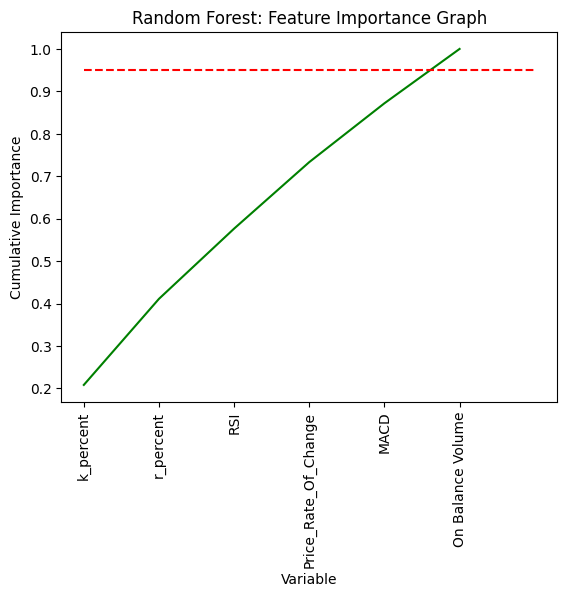

In [23]:

# store the values in a list to plot.
x_values = list(range(len(rand_frst_clf.feature_importances_)))

# Cumulative importances
cumulative_importances = np.cumsum(feature_imp.values)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin = 0, xmax = len(feature_imp), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, feature_imp.index, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable')
plt.ylabel('Cumulative Importance')
plt.title('Random Forest: Feature Importance Graph')
rfc_disp = RocCurveDisplay(rand_frst_clf, X_test, y_test, alpha = 0.8)
plt.show()


In [24]:
rfc_disp = RocCurveDisplay(rand_frst_clf, X_test, y_test, alpha = 0.8)
plt.show()


TypeError: RocCurveDisplay.__init__() got an unexpected keyword argument 'alpha'

In [25]:

print('Random Forest Out-Of-Bag Error Score: {}'.format(rand_frst_clf.oob_score_))


Random Forest Out-Of-Bag Error Score: 0.6693877551020408


In [26]:

# Number of trees in random forest
# Number of trees is not a parameter that should be tuned, but just set large enough usually. There is no risk of overfitting in random forest with growing number of # trees, as they are trained independently from each other. 
n_estimators = list(range(200, 2000, 200))

# Number of features to consider at every split
max_features = ['auto', 'sqrt', None, 'log2']

# Maximum number of levels in tree
# Max depth is a parameter that most of the times should be set as high as possible, but possibly better performance can be achieved by setting it lower.
max_depth = list(range(10, 110, 10))
max_depth.append(None)

# Minimum number of samples required to split a node
# Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree. Too high values can also lead to # under-fitting hence depending on the level of underfitting or overfitting, you can tune the values for min_samples_split.
min_samples_split = [2, 5, 10, 20, 30, 40]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 7, 12, 14, 16 ,20]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)


{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800], 'max_features': ['auto', 'sqrt', None, 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10, 20, 30, 40], 'min_samples_leaf': [1, 2, 7, 12, 14, 16, 20], 'bootstrap': [True, False]}


In [29]:

# New Random Forest Classifier to house optimal parameters
rf = RandomForestClassifier()

# Specfiy the details of our Randomized Search
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)
# With the new Random Classifier trained we can proceed to our regular steps, prediction.
rf_random.predict(X_test)


'''
    ACCURACY
'''
# Once the predictions have been made, then grab the accuracy score.
print('Correct Prediction (%): ', accuracy_score(y_test, rf_random.predict(X_test), normalize = True) * 100.0)



'''
    CLASSIFICATION REPORT
'''
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
display(report_df)
print('\n')

'''
    FEATURE IMPORTANCE
'''
# Calculate feature importance and store in pandas series
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_Cols.columns).sort_values(ascending=False)
display(feature_imp)# With the new Random Classifier trained we can proceed to our regular steps, prediction.
rf_random.predict(X_test)


'''
    ACCURACY
'''
# Once the predictions have been made, then grab the accuracy score.
print('Correct Prediction (%): ', accuracy_score(y_test, rf_random.predict(X_test), normalize = True) * 100.0)


'''
    CLASSIFICATION REPORT
'''
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
display(report_df)
print('\n')

'''
    FEATURE IMPORTANCE
'''
# Calculate feature importance and store in pandas series
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_Cols.columns).sort_values(ascending=False)
display(feature_imp)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=16, min_samples_split=20, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=16, min_samples_split=20, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=16, min_samples_split=20, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=40, n_estimators=1200; total time=   2.4s
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=40, n_estimators=1200; total time=   2.3s
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=40, n_estimators=1200; total time=   2.4s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=14, min_samples_split=2, n_e

/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
75 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py", line 1344, in wrapper
    estimator._validate_params()
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/

Correct Prediction (%):  73.17073170731707


,precision,recall,f1-score,support
Down Day,0.769231,0.769231,0.769231,39.000000
Up Day,0.790698,0.790698,0.790698,43.000000
accuracy,0.780488,0.780488,0.780488,0.780488
macro avg,0.779964,0.779964,0.779964,82.000000
weighted avg,0.780488,0.780488,0.780488,82.000000


k_percent               0.208225
r_percent               0.202867
RSI                     0.165493
Price_Rate_Of_Change    0.156711
MACD                    0.138623
On Balance Volume       0.128081
dtype: float64

Correct Prediction (%):  73.17073170731707


,precision,recall,f1-score,support
Down Day,0.769231,0.769231,0.769231,39.000000
Up Day,0.790698,0.790698,0.790698,43.000000
accuracy,0.780488,0.780488,0.780488,0.780488
macro avg,0.779964,0.779964,0.779964,82.000000
weighted avg,0.780488,0.780488,0.780488,82.000000


k_percent               0.208225
r_percent               0.202867
RSI                     0.165493
Price_Rate_Of_Change    0.156711
MACD                    0.138623
On Balance Volume       0.128081
dtype: float64

TypeError: RocCurveDisplay.__init__() got an unexpected keyword argument 'alpha'

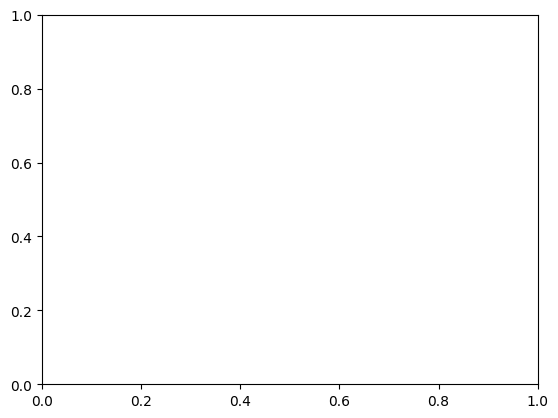

In [28]:

'''
    ROC CURVE
'''

fig, ax = plt.subplots()

# Create an ROC Curve plot.
rfc_disp = RocCurveDisplay(rand_frst_clf, X_test, y_test, alpha = 0.8, name='ROC Curve', lw=1, ax=ax)

# Add our Chance Line
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

# Make it look pretty.
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="ROC Curve Random Forest")

# Add the legend to the plot
ax.legend(loc="lower right")

plt.show()